In [1]:
import pandas as pd
patients = pd.read_csv("Data/trainData/patients.csv")
conditions = pd.read_csv("Data/trainData/conditions.csv")

medications = pd.read_csv("Data/trainData/medications.csv")

merged = pd.merge(conditions, patients, left_on="Patient_id", right_on="Id")
merged.drop(["Patient_id"], inplace=True, axis=1)

In [2]:
lung = merged[merged["Diagnosis"] == "Suspected lung cancer (situation)"]

In [3]:
import pandas as pd

# Assuming you have already read the medications and lung DataFrames
# medications = pd.read_csv("Data/trainData/medications.csv")
# lung = ...

# Merge medications with lung DataFrame to associate medications with diagnosis dates
merged_data = pd.merge(medications, lung, left_on="Patient_id", right_on="Id")

# Convert the "Start" and "Diagnosis" columns to datetime
merged_data["Start"] = pd.to_datetime(merged_data["Start_x"], format="%Y-%m-%dT%H:%M:%SZ")
merged_data["Diagnosis"] = pd.to_datetime(merged_data["Start_y"], format="%d/%m/%Y")

# Filter the DataFrame based on the specified conditions
filtered_medications = merged_data[
    ((merged_data["Reason"] == "Non-small cell carcinoma of lung  TNM stage 1 (disorder)") |
    (merged_data["Reason"] == "Primary small cell malignant neoplasm of lung  TNM stage 1 (disorder)")) &
    (merged_data["Start"] >= merged_data["Diagnosis"]) &  # Only include medications after diagnosis
    (merged_data["Start"] <= merged_data["Diagnosis"] + pd.DateOffset(days=365))  # Only include medications in the first year
]

# Count the unique medications for each patient
treatment_counts = filtered_medications.groupby("Id").size().reset_index(name="Treatment_Count")

# Display the resulting DataFrame
#print(treatment_counts)

                                       Id  Treatment_Count
0    00c31453-432b-21bb-fb46-3d42ba1c353b              122
1    018bdaba-d2a5-5922-fba7-91023e519bde              120
2    01a8014e-c54b-5bd2-5768-c54dbcf4f54f              124
3    01dbfef7-0fe5-99a4-ad97-ff32c0f724fc              122
4    02781c5e-a886-4d49-2ed6-98abeee54f6c               96
..                                    ...              ...
691  fc82fa4d-7093-9921-b675-71a5db9921e5              126
692  fd160817-4cdd-5000-7ff0-630ff022e240              102
693  fdfeedc4-a6e4-1d65-1ac1-39ed620c105c              106
694  fe60d2db-8855-c641-84e5-8fd9325e6973               94
695  ff14e39d-65a6-aa9a-b339-79c55dae689e              100

[696 rows x 2 columns]


In [4]:
from datetime import datetime, timedelta
import pandas as pd

# Assuming you have already imported your DataFrame as 'merged'

# Convert "Start" column to datetime format
lung["Start"] = pd.to_datetime(lung["Start"], format="%d/%m/%Y")

# Calculate the date 5 years ago
five_years_ago = datetime.now() - timedelta(days=5*365)

# Drop rows where "Start" date is less than 5 years ago
lung = lung[lung["Start"] < five_years_ago]

C:\Users\opuusalu\AppData\Local\Temp\ipykernel_11196\3331434310.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lung["Start"] = pd.to_datetime(lung["Start"], format="%d/%m/%Y")


In [5]:
from datetime import datetime, timedelta
import pandas as pd

# Assuming you have already imported your DataFrame as 'merged'

# Convert "Start" and "DeathDate" columns to datetime format
lung["Start"] = pd.to_datetime(lung["Start"], format="%d/%m/%Y")
lung["DeathDate"] = pd.to_datetime(lung["DeathDate"], format="%d/%m/%Y", errors='coerce')

# Calculate today's date
today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)

# Set missing "DeathDate" values to today
lung.loc[lung["DeathDate"].isna(), "DeathDate"] = today


In [6]:
from datetime import datetime, timedelta
import pandas as pd

# Assuming you have already imported your DataFrame as 'merged'

# Convert "Start" and "DeathDate" columns to datetime format
lung["Start"] = pd.to_datetime(lung["Start"], format="%d/%m/%Y")
lung["DeathDate"] = pd.to_datetime(lung["DeathDate"], format="%d/%m/%Y", errors='coerce')

# Calculate the date difference
lung["date_difference"] = lung["DeathDate"] - lung["Start"]

# Set missing "DeathDate" values to today
today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
lung.loc[merged["DeathDate"].isna(), "DeathDate"] = today

# Create a new column "y" based on the condition
lung["y"] = (lung["date_difference"] > timedelta(days=1825)).astype(int)


In [7]:
# Assuming your DataFrame is named 'merged'
columns_to_drop = ["date_difference", "BirthDate", "DeathDate"]

# Drop the specified columns
lung.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [8]:
encoded = pd.get_dummies(conditions, columns=["Diagnosis"])


columns = encoded.columns[4:]
#for i in range(4, encoded.columns.count):
 #   print(encoded.columns[i])
aggregated = encoded.groupby("Patient_id").agg({**{col: 'max' for col in columns}})

In [18]:
merged = pd.merge(aggregated, lung[["Id", "y", "Gender"]], left_on="Patient_id", right_on="Id")
merged["Gender"] = merged["Gender"] == "F"
merged = pd.merge(merged, treatment_counts[["Id","Treatment_Count"]], left_on="Id", right_on="Id")

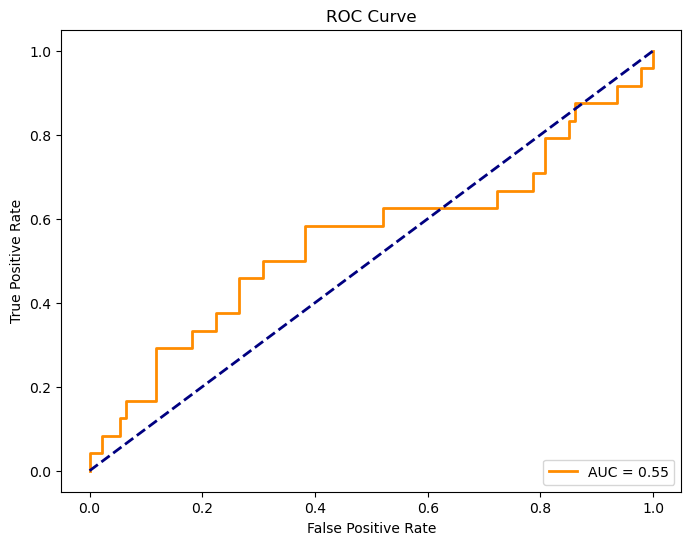

AUC: 0.55


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


# Assuming your DataFrame is named 'merged'

# Drop unnecessary columns
X = merged.drop(columns=["y", "Id"])
y = merged["y"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest Classifier with some hyperparameter tuning
classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_proba = classifier.predict_proba(X_test)[:, 1]  # Probability of class 1

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f'AUC: {roc_auc:.2f}')

C:\Users\opuusalu\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


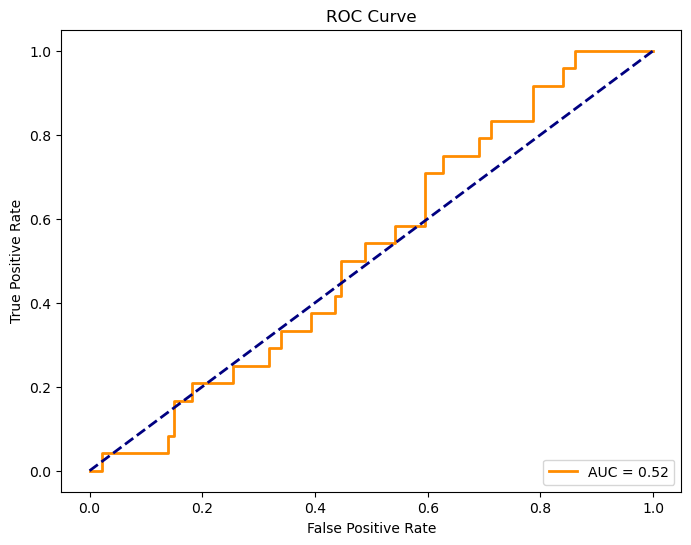

AUC: 0.52


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'merged'

# Drop unnecessary columns
X = merged.drop(columns=["y", "Id"])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, merged["y"], test_size=0.2, random_state=42)

# Train a model (e.g., Logistic Regression)
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of class 1

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f'AUC: {roc_auc:.2f}')

In [16]:
import numpy as np

# Assuming y_pred is your NumPy array
unique_values, counts = np.unique(y_pred_proba, return_counts=True)

# Create a dictionary to display the counts
counts_dict = dict(zip(unique_values, counts))

print("Predicted Value Counts:")
print(counts_dict)

Predicted Value Counts:
{0.030963184002820835: 1, 0.036997982328330445: 1, 0.04069129582534519: 1, 0.04206994473602588: 1, 0.054757248709640896: 1, 0.05486753170697689: 1, 0.056888108395441395: 1, 0.05972308051230714: 1, 0.06459117431976141: 1, 0.06528315634367104: 1, 0.07038259871203151: 1, 0.07157363762952894: 1, 0.07232834370963648: 1, 0.07275011617723773: 1, 0.07834906984793512: 1, 0.07868329224809008: 1, 0.08292331484803483: 1, 0.08790130015717626: 1, 0.090712085536218: 1, 0.10125321983073003: 1, 0.10215296077965898: 1, 0.10219564950820048: 1, 0.1029059585919491: 1, 0.10319662111846466: 1, 0.10367204597085518: 1, 0.10666439398462498: 1, 0.11122499336337759: 1, 0.11254164452152496: 1, 0.11514675656369008: 1, 0.11706678303684248: 1, 0.11741910639381523: 1, 0.11806256202735763: 1, 0.12660506497492308: 1, 0.12842324762260754: 1, 0.13408691225980857: 1, 0.1353473752409548: 1, 0.13758962140096212: 1, 0.13827518656821655: 1, 0.13852704943691682: 1, 0.13984365831544207: 1, 0.1412534924398